# Proyecto Final. Generación de sintética de tomografías.

Reconocomiento de Patrones

Andrés González Flores


In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import glob
import imageio
import codecs
import hashlib 
import time

# Set random seed for reproducibility
manualSeed = 550
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  550


## Inputs

Let’s define some inputs for the run:

- **dataroot** - the path to the root of the dataset folder. We will talk more about the dataset in the next section
- **workers** - the number of worker threads for loading the data with the DataLoader
- **batch_size** - the batch size used in training. The DCGAN paper uses a batch size of 128
- **image_size** - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
- **nc** - number of color channels in the input images. For color images this is 3
- **nz** - length of latent vector
- **ngf** - relates to the depth of feature maps carried through the generator
- **ndf** - sets the depth of feature maps propagated through the discriminator
- **num_epochs** - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
- **lr** - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
- **beta1** - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
- **ngpu** - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [2]:
# Root directory for dataset
dataroot = "dataset"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
dlr = 0.00005 
glr = 0.0002 

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Imágenes para animación gif
nimgif = 12

## Data
In this tutorial we will use the Celeb-A Faces dataset which can be downloaded at the linked site, or in Google Drive. The dataset will download as a file named img_align_celeba.zip. Once downloaded, create a directory named celeba and extract the zip file into that directory. Then, set the dataroot input for this notebook to the celeba directory you just created. The resulting directory structure should be:

/path/to/celeba
    -> img_align_celeba
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...
       
This is an important step because we will be using the ImageFolder dataset class, which requires there to be subdirectories in the dataset’s root folder. Now, we can create the dataset, create the dataloader, set the device to run on, and finally visualize some of the training data.

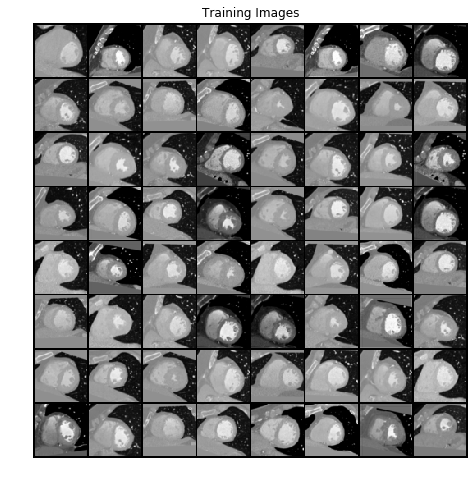

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5]),
                           ]))

# Número de imágenes en el dataset
n_imgs = len(dataset.imgs)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Para generar imágenes de muestra cuadradas
if batch_size<64:
    vector_cuad = [x**2 for x in range(1, 9)]
    indice = np.floor(np.sqrt(32)).astype(np.uint8)-1
    n_img_grid = vector_cuad[indice]
else:
    n_img_grid = 64

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:n_img_grid], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Implementation
With our input parameters set and the dataset prepared, we can now get into the implementation. We will start with the weigth initialization strategy, then talk about the generator, discriminator, loss functions, and training loop in detail.

### Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator
The generator, G, is designed to map the latent space vector (z) to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of \[−1,1\]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

![Generador](dcgan_generator.png)

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.

In [5]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the weights_init function. Check out the printed model to see how the generator object is structured.

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator

As mentioned, the discriminator, D, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.

Discriminator Code

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the weights_init function, and print the model’s structure.

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers
With D and G setup, we can specify how they learn through the loss functions and optimizers. We will use the Binary Cross Entropy loss (BCELoss) function which is defined in PyTorch as:

ℓ(x,y)=L={l<sub>1</sub>,…,l<sub>N</sub>}<sup>T</sup>,l<sub>n</sub>=−\[y<sub>n</sub>⋅logx<sub>n</sub>+(1−y<sub>n</sub>)⋅log(1−x<sub>n</sub>)\]

Notice how this function provides the calculation of both log components in the objective function (i.e. log(D(x)) and log(1−D(G(z)))). We can specify what part of the BCE equation to use with the y input. This is accomplished in the training loop which is coming up soon, but it is important to understand how we can choose which component we wish to calculate just by changing y (i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of D and G, and this is also the convention used in the original GAN paper. Finally, we set up two separate optimizers, one for D and one for G. As specified in the DCGAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution (i.e. fixed_noise) . In the training loop, we will periodically input this fixed_noise into G, and over the iterations we will see images form out of the noise.

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=dlr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=glr, betas=(beta1, 0.999))

### Training
Finally, now that we have all of the parts of the GAN framework defined, we can train it. Be mindful that training GANs is somewhat of an art form, as incorrect hyperparameter settings lead to mode collapse with little explanation of what went wrong. Here, we will closely follow Algorithm 1 from Goodfellow’s paper, while abiding by some of the best practices shown in ganhacks. Namely, we will “construct different mini-batches for real and fake” images, and also adjust G’s objective function to maximize logD(G(z)). Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator.

#### Part 1 - Train the Discriminator

Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”. Practically, we want to maximize log(D(x))+log(1−D(G(z))). Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through D, calculate the loss (log(D(x))), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss (log(1−D(G(z)))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

#### Part 2 - Train the Generator

As stated in the original paper, we want to train the Generator by minimizing log(1−D(G(z))) in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize log(D(G(z))). In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the log(x) part of the BCELoss (rather than the log(1−x) part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. The training statistics reported are:

- Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x))+log(D(G(z)))).
- Loss_G - generator loss calculated as log(D(G(z)))
- D(x) - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
- D(G(z)) - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.

Note: This step might take a while, depending on how many epochs you run and if you removed some data from the dataset.

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Guardar imágenes cada i iteraciones
modulo = np.ceil(num_epochs*np.round(n_imgs/batch_size)/(nimgif-1))

print("Starting Training Loop...")
# For each epoch
start = time.time()
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % modulo == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
end = time.time()
t_entrenamiento = end-start

Starting Training Loop...
[0/1000][0/4]	Loss_D: 2.0698	Loss_G: 1.3102	D(x): 0.3020	D(G(z)): 0.4416 / 0.3209
[1/1000][0/4]	Loss_D: 3.5537	Loss_G: 0.4561	D(x): 0.9561	D(G(z)): 0.9594 / 0.6607
[2/1000][0/4]	Loss_D: 2.9732	Loss_G: 1.1227	D(x): 0.8581	D(G(z)): 0.9196 / 0.3739
[3/1000][0/4]	Loss_D: 2.7515	Loss_G: 1.9010	D(x): 0.8313	D(G(z)): 0.8807 / 0.2079
[4/1000][0/4]	Loss_D: 1.9228	Loss_G: 3.2477	D(x): 0.8429	D(G(z)): 0.7872 / 0.0508
[5/1000][0/4]	Loss_D: 1.1895	Loss_G: 4.1698	D(x): 0.8643	D(G(z)): 0.5882 / 0.0214
[6/1000][0/4]	Loss_D: 1.0549	Loss_G: 4.5265	D(x): 0.8651	D(G(z)): 0.5362 / 0.0162
[7/1000][0/4]	Loss_D: 0.9942	Loss_G: 5.3111	D(x): 0.8434	D(G(z)): 0.5136 / 0.0071
[8/1000][0/4]	Loss_D: 1.1475	Loss_G: 5.3181	D(x): 0.8541	D(G(z)): 0.5811 / 0.0070
[9/1000][0/4]	Loss_D: 0.6598	Loss_G: 5.0381	D(x): 0.8935	D(G(z)): 0.3832 / 0.0091
[10/1000][0/4]	Loss_D: 0.6177	Loss_G: 5.5575	D(x): 0.8919	D(G(z)): 0.3693 / 0.0049
[11/1000][0/4]	Loss_D: 0.5318	Loss_G: 5.1561	D(x): 0.8830	D(G(z)): 0.30

[98/1000][0/4]	Loss_D: 0.3172	Loss_G: 3.0293	D(x): 0.8891	D(G(z)): 0.1523 / 0.0636
[99/1000][0/4]	Loss_D: 0.2731	Loss_G: 3.1515	D(x): 0.8964	D(G(z)): 0.1360 / 0.0602
[100/1000][0/4]	Loss_D: 0.3720	Loss_G: 2.4465	D(x): 0.8155	D(G(z)): 0.1256 / 0.1061
[101/1000][0/4]	Loss_D: 0.5869	Loss_G: 5.5382	D(x): 0.9405	D(G(z)): 0.3793 / 0.0063
[102/1000][0/4]	Loss_D: 0.3671	Loss_G: 2.5820	D(x): 0.7628	D(G(z)): 0.0495 / 0.0956
[103/1000][0/4]	Loss_D: 0.6214	Loss_G: 1.7070	D(x): 0.6624	D(G(z)): 0.1336 / 0.2118
[104/1000][0/4]	Loss_D: 0.4662	Loss_G: 2.4356	D(x): 0.7707	D(G(z)): 0.1555 / 0.1034
[105/1000][0/4]	Loss_D: 0.6870	Loss_G: 1.1289	D(x): 0.5897	D(G(z)): 0.0653 / 0.3541
[106/1000][0/4]	Loss_D: 0.3478	Loss_G: 3.5691	D(x): 0.9513	D(G(z)): 0.2502 / 0.0320
[107/1000][0/4]	Loss_D: 0.3655	Loss_G: 3.1526	D(x): 0.8723	D(G(z)): 0.1936 / 0.0540
[108/1000][0/4]	Loss_D: 0.3370	Loss_G: 2.3278	D(x): 0.8376	D(G(z)): 0.1340 / 0.1186
[109/1000][0/4]	Loss_D: 0.4902	Loss_G: 3.7183	D(x): 0.9174	D(G(z)): 0.3164 / 0

[195/1000][0/4]	Loss_D: 0.1836	Loss_G: 2.8169	D(x): 0.8927	D(G(z)): 0.0647 / 0.0713
[196/1000][0/4]	Loss_D: 0.2217	Loss_G: 2.3814	D(x): 0.8795	D(G(z)): 0.0828 / 0.1115
[197/1000][0/4]	Loss_D: 0.2133	Loss_G: 2.4878	D(x): 0.8697	D(G(z)): 0.0673 / 0.1026
[198/1000][0/4]	Loss_D: 0.1723	Loss_G: 2.9418	D(x): 0.9382	D(G(z)): 0.0990 / 0.0693
[199/1000][0/4]	Loss_D: 0.2436	Loss_G: 2.3720	D(x): 0.8248	D(G(z)): 0.0416 / 0.1271
[200/1000][0/4]	Loss_D: 0.1791	Loss_G: 2.8576	D(x): 0.9347	D(G(z)): 0.1008 / 0.0757
[201/1000][0/4]	Loss_D: 0.1831	Loss_G: 2.7622	D(x): 0.8958	D(G(z)): 0.0669 / 0.0867
[202/1000][0/4]	Loss_D: 0.3281	Loss_G: 3.8260	D(x): 0.9614	D(G(z)): 0.2284 / 0.0330
[203/1000][0/4]	Loss_D: 0.1772	Loss_G: 2.5516	D(x): 0.9351	D(G(z)): 0.1006 / 0.1044
[204/1000][0/4]	Loss_D: 0.2106	Loss_G: 2.9251	D(x): 0.8995	D(G(z)): 0.0937 / 0.0704
[205/1000][0/4]	Loss_D: 0.2244	Loss_G: 2.2331	D(x): 0.8377	D(G(z)): 0.0414 / 0.1444
[206/1000][0/4]	Loss_D: 0.2112	Loss_G: 3.2953	D(x): 0.8883	D(G(z)): 0.0826 /

[292/1000][0/4]	Loss_D: 0.1185	Loss_G: 3.6090	D(x): 0.9687	D(G(z)): 0.0813 / 0.0364
[293/1000][0/4]	Loss_D: 0.1188	Loss_G: 3.1549	D(x): 0.9274	D(G(z)): 0.0410 / 0.0545
[294/1000][0/4]	Loss_D: 0.1719	Loss_G: 2.4670	D(x): 0.8646	D(G(z)): 0.0233 / 0.1065
[295/1000][0/4]	Loss_D: 0.1290	Loss_G: 3.2572	D(x): 0.9639	D(G(z)): 0.0819 / 0.0551
[296/1000][0/4]	Loss_D: 0.1181	Loss_G: 3.3352	D(x): 0.9394	D(G(z)): 0.0511 / 0.0474
[297/1000][0/4]	Loss_D: 0.1103	Loss_G: 3.3282	D(x): 0.9380	D(G(z)): 0.0439 / 0.0459
[298/1000][0/4]	Loss_D: 0.1069	Loss_G: 3.6644	D(x): 0.9579	D(G(z)): 0.0585 / 0.0371
[299/1000][0/4]	Loss_D: 0.1358	Loss_G: 3.8682	D(x): 0.9428	D(G(z)): 0.0678 / 0.0319
[300/1000][0/4]	Loss_D: 0.1025	Loss_G: 3.5166	D(x): 0.9548	D(G(z)): 0.0512 / 0.0411
[301/1000][0/4]	Loss_D: 0.1375	Loss_G: 3.2883	D(x): 0.9430	D(G(z)): 0.0736 / 0.0467
[302/1000][0/4]	Loss_D: 0.1259	Loss_G: 3.2045	D(x): 0.9614	D(G(z)): 0.0805 / 0.0522
[303/1000][0/4]	Loss_D: 0.1093	Loss_G: 3.9613	D(x): 0.9670	D(G(z)): 0.0702 /

[389/1000][0/4]	Loss_D: 0.0704	Loss_G: 4.0515	D(x): 0.9776	D(G(z)): 0.0453 / 0.0248
[390/1000][0/4]	Loss_D: 0.1480	Loss_G: 3.4617	D(x): 0.8761	D(G(z)): 0.0121 / 0.0477
[391/1000][0/4]	Loss_D: 0.0805	Loss_G: 3.6748	D(x): 0.9502	D(G(z)): 0.0270 / 0.0378
[392/1000][0/4]	Loss_D: 0.0820	Loss_G: 3.7115	D(x): 0.9642	D(G(z)): 0.0417 / 0.0371
[393/1000][0/4]	Loss_D: 0.0799	Loss_G: 4.1551	D(x): 0.9416	D(G(z)): 0.0185 / 0.0240
[394/1000][0/4]	Loss_D: 0.1586	Loss_G: 2.9527	D(x): 0.8716	D(G(z)): 0.0159 / 0.0814
[395/1000][0/4]	Loss_D: 0.1236	Loss_G: 3.2718	D(x): 0.9723	D(G(z)): 0.0853 / 0.0540
[396/1000][0/4]	Loss_D: 0.0826	Loss_G: 3.4915	D(x): 0.9775	D(G(z)): 0.0564 / 0.0434
[397/1000][0/4]	Loss_D: 0.0507	Loss_G: 3.9313	D(x): 0.9786	D(G(z)): 0.0283 / 0.0258
[398/1000][0/4]	Loss_D: 0.1199	Loss_G: 4.1425	D(x): 0.9696	D(G(z)): 0.0780 / 0.0244
[399/1000][0/4]	Loss_D: 0.1044	Loss_G: 3.3856	D(x): 0.9634	D(G(z)): 0.0625 / 0.0478
[400/1000][0/4]	Loss_D: 0.1201	Loss_G: 3.0933	D(x): 0.9376	D(G(z)): 0.0515 /

[486/1000][0/4]	Loss_D: 0.0942	Loss_G: 3.9935	D(x): 0.9492	D(G(z)): 0.0379 / 0.0316
[487/1000][0/4]	Loss_D: 0.1257	Loss_G: 4.3369	D(x): 0.9756	D(G(z)): 0.0888 / 0.0234
[488/1000][0/4]	Loss_D: 0.1197	Loss_G: 3.3422	D(x): 0.9245	D(G(z)): 0.0360 / 0.0604
[489/1000][0/4]	Loss_D: 0.0996	Loss_G: 4.5246	D(x): 0.9631	D(G(z)): 0.0569 / 0.0185
[490/1000][0/4]	Loss_D: 0.1231	Loss_G: 4.6716	D(x): 0.9786	D(G(z)): 0.0909 / 0.0133
[491/1000][0/4]	Loss_D: 0.1048	Loss_G: 4.4667	D(x): 0.9704	D(G(z)): 0.0651 / 0.0221
[492/1000][0/4]	Loss_D: 0.0813	Loss_G: 4.1195	D(x): 0.9635	D(G(z)): 0.0400 / 0.0247
[493/1000][0/4]	Loss_D: 0.1370	Loss_G: 4.8757	D(x): 0.9720	D(G(z)): 0.0946 / 0.0131
[494/1000][0/4]	Loss_D: 0.1388	Loss_G: 3.6723	D(x): 0.9060	D(G(z)): 0.0199 / 0.0401
[495/1000][0/4]	Loss_D: 0.0908	Loss_G: 3.5866	D(x): 0.9475	D(G(z)): 0.0324 / 0.0436
[496/1000][0/4]	Loss_D: 0.1370	Loss_G: 4.8227	D(x): 0.9860	D(G(z)): 0.1075 / 0.0136
[497/1000][0/4]	Loss_D: 0.1119	Loss_G: 4.4682	D(x): 0.9759	D(G(z)): 0.0788 /

[583/1000][0/4]	Loss_D: 0.0431	Loss_G: 5.0198	D(x): 0.9842	D(G(z)): 0.0261 / 0.0122
[584/1000][0/4]	Loss_D: 0.0354	Loss_G: 5.4829	D(x): 0.9848	D(G(z)): 0.0194 / 0.0099
[585/1000][0/4]	Loss_D: 0.0955	Loss_G: 4.7186	D(x): 0.9712	D(G(z)): 0.0516 / 0.0169
[586/1000][0/4]	Loss_D: 0.0432	Loss_G: 4.4746	D(x): 0.9701	D(G(z)): 0.0114 / 0.0188
[587/1000][0/4]	Loss_D: 0.0377	Loss_G: 4.8972	D(x): 0.9835	D(G(z)): 0.0203 / 0.0130
[588/1000][0/4]	Loss_D: 0.0795	Loss_G: 5.0291	D(x): 0.9920	D(G(z)): 0.0631 / 0.0110
[589/1000][0/4]	Loss_D: 0.0298	Loss_G: 4.9103	D(x): 0.9842	D(G(z)): 0.0133 / 0.0118
[590/1000][0/4]	Loss_D: 0.0646	Loss_G: 4.4954	D(x): 0.9747	D(G(z)): 0.0357 / 0.0228
[591/1000][0/4]	Loss_D: 0.0370	Loss_G: 4.2915	D(x): 0.9879	D(G(z)): 0.0241 / 0.0211
[592/1000][0/4]	Loss_D: 0.0486	Loss_G: 4.1921	D(x): 0.9808	D(G(z)): 0.0271 / 0.0261
[593/1000][0/4]	Loss_D: 0.0537	Loss_G: 4.5324	D(x): 0.9639	D(G(z)): 0.0149 / 0.0171
[594/1000][0/4]	Loss_D: 0.0785	Loss_G: 4.0384	D(x): 0.9443	D(G(z)): 0.0147 /

[680/1000][0/4]	Loss_D: 0.0503	Loss_G: 4.4669	D(x): 0.9880	D(G(z)): 0.0372 / 0.0144
[681/1000][0/4]	Loss_D: 0.0298	Loss_G: 4.6462	D(x): 0.9855	D(G(z)): 0.0146 / 0.0138
[682/1000][0/4]	Loss_D: 0.0750	Loss_G: 3.8389	D(x): 0.9470	D(G(z)): 0.0154 / 0.0348
[683/1000][0/4]	Loss_D: 0.0271	Loss_G: 4.6497	D(x): 0.9975	D(G(z)): 0.0240 / 0.0154
[684/1000][0/4]	Loss_D: 0.0607	Loss_G: 4.5396	D(x): 0.9949	D(G(z)): 0.0517 / 0.0159
[685/1000][0/4]	Loss_D: 0.0698	Loss_G: 5.2054	D(x): 0.9929	D(G(z)): 0.0566 / 0.0102
[686/1000][0/4]	Loss_D: 0.0417	Loss_G: 4.5017	D(x): 0.9890	D(G(z)): 0.0296 / 0.0177
[687/1000][0/4]	Loss_D: 0.0531	Loss_G: 5.0071	D(x): 0.9956	D(G(z)): 0.0454 / 0.0107
[688/1000][0/4]	Loss_D: 0.0554	Loss_G: 4.7713	D(x): 0.9949	D(G(z)): 0.0471 / 0.0123
[689/1000][0/4]	Loss_D: 0.0493	Loss_G: 4.8440	D(x): 0.9969	D(G(z)): 0.0432 / 0.0136
[690/1000][0/4]	Loss_D: 0.0671	Loss_G: 4.2529	D(x): 0.9861	D(G(z)): 0.0494 / 0.0235
[691/1000][0/4]	Loss_D: 0.0435	Loss_G: 4.4032	D(x): 0.9726	D(G(z)): 0.0149 /

[777/1000][0/4]	Loss_D: 0.0834	Loss_G: 5.1105	D(x): 0.9877	D(G(z)): 0.0636 / 0.0105
[778/1000][0/4]	Loss_D: 0.0477	Loss_G: 5.3888	D(x): 0.9688	D(G(z)): 0.0147 / 0.0088
[779/1000][0/4]	Loss_D: 0.0465	Loss_G: 4.5758	D(x): 0.9929	D(G(z)): 0.0378 / 0.0158
[780/1000][0/4]	Loss_D: 0.0503	Loss_G: 4.7888	D(x): 0.9827	D(G(z)): 0.0314 / 0.0132
[781/1000][0/4]	Loss_D: 0.0288	Loss_G: 4.9400	D(x): 0.9844	D(G(z)): 0.0126 / 0.0121
[782/1000][0/4]	Loss_D: 0.0436	Loss_G: 5.0107	D(x): 0.9743	D(G(z)): 0.0164 / 0.0109
[783/1000][0/4]	Loss_D: 0.0610	Loss_G: 4.8083	D(x): 0.9558	D(G(z)): 0.0135 / 0.0148
[784/1000][0/4]	Loss_D: 0.0301	Loss_G: 5.4931	D(x): 0.9812	D(G(z)): 0.0108 / 0.0070
[785/1000][0/4]	Loss_D: 0.0429	Loss_G: 4.9138	D(x): 0.9822	D(G(z)): 0.0240 / 0.0107
[786/1000][0/4]	Loss_D: 0.0721	Loss_G: 3.6205	D(x): 0.9772	D(G(z)): 0.0469 / 0.0405
[787/1000][0/4]	Loss_D: 0.0304	Loss_G: 4.5329	D(x): 0.9799	D(G(z)): 0.0085 / 0.0157
[788/1000][0/4]	Loss_D: 0.0444	Loss_G: 4.6333	D(x): 0.9872	D(G(z)): 0.0303 /

[874/1000][0/4]	Loss_D: 0.0442	Loss_G: 4.6922	D(x): 0.9634	D(G(z)): 0.0057 / 0.0124
[875/1000][0/4]	Loss_D: 0.0596	Loss_G: 4.5131	D(x): 0.9526	D(G(z)): 0.0039 / 0.0179
[876/1000][0/4]	Loss_D: 0.0207	Loss_G: 5.0753	D(x): 0.9905	D(G(z)): 0.0111 / 0.0086
[877/1000][0/4]	Loss_D: 0.0345	Loss_G: 4.6702	D(x): 0.9902	D(G(z)): 0.0241 / 0.0128
[878/1000][0/4]	Loss_D: 0.0272	Loss_G: 5.1261	D(x): 0.9969	D(G(z)): 0.0237 / 0.0076
[879/1000][0/4]	Loss_D: 0.0385	Loss_G: 4.5400	D(x): 0.9756	D(G(z)): 0.0087 / 0.0147
[880/1000][0/4]	Loss_D: 0.0283	Loss_G: 5.0591	D(x): 0.9881	D(G(z)): 0.0158 / 0.0142
[881/1000][0/4]	Loss_D: 0.0619	Loss_G: 4.8624	D(x): 0.9814	D(G(z)): 0.0408 / 0.0097
[882/1000][0/4]	Loss_D: 0.0415	Loss_G: 4.4509	D(x): 0.9694	D(G(z)): 0.0083 / 0.0187
[883/1000][0/4]	Loss_D: 0.0350	Loss_G: 5.0589	D(x): 0.9971	D(G(z)): 0.0308 / 0.0100
[884/1000][0/4]	Loss_D: 0.0236	Loss_G: 5.0759	D(x): 0.9882	D(G(z)): 0.0114 / 0.0092
[885/1000][0/4]	Loss_D: 0.0244	Loss_G: 5.1576	D(x): 0.9838	D(G(z)): 0.0072 /

[971/1000][0/4]	Loss_D: 0.0461	Loss_G: 4.3800	D(x): 0.9922	D(G(z)): 0.0365 / 0.0192
[972/1000][0/4]	Loss_D: 0.0219	Loss_G: 4.8977	D(x): 0.9935	D(G(z)): 0.0150 / 0.0106
[973/1000][0/4]	Loss_D: 0.0557	Loss_G: 4.4444	D(x): 0.9613	D(G(z)): 0.0135 / 0.0225
[974/1000][0/4]	Loss_D: 0.0345	Loss_G: 4.9488	D(x): 0.9743	D(G(z)): 0.0065 / 0.0108
[975/1000][0/4]	Loss_D: 0.0416	Loss_G: 4.5066	D(x): 0.9892	D(G(z)): 0.0296 / 0.0152
[976/1000][0/4]	Loss_D: 0.0269	Loss_G: 4.6198	D(x): 0.9874	D(G(z)): 0.0137 / 0.0135
[977/1000][0/4]	Loss_D: 0.0245	Loss_G: 5.0821	D(x): 0.9865	D(G(z)): 0.0107 / 0.0088
[978/1000][0/4]	Loss_D: 0.0346	Loss_G: 4.9373	D(x): 0.9862	D(G(z)): 0.0199 / 0.0121
[979/1000][0/4]	Loss_D: 0.0389	Loss_G: 4.9511	D(x): 0.9811	D(G(z)): 0.0185 / 0.0121
[980/1000][0/4]	Loss_D: 0.0310	Loss_G: 4.8852	D(x): 0.9842	D(G(z)): 0.0141 / 0.0131
[981/1000][0/4]	Loss_D: 0.0485	Loss_G: 4.8921	D(x): 0.9902	D(G(z)): 0.0362 / 0.0117
[982/1000][0/4]	Loss_D: 0.0383	Loss_G: 7.0498	D(x): 0.9678	D(G(z)): 0.0041 /

**Tiempo de entrenamiento**

In [11]:
(t_ent, seg) = divmod(np.round(t_entrenamiento), 60) 
(t_ent, minut) = divmod(t_ent, 60)
(t_ent, horas) = divmod(t_ent, 60) 
(t_ent, dias) = divmod(t_ent, 24) 
print('Tiempo de entrenamiento: ', end='')
if dias > 0:
    print('%d día(s), ' % dias, end='')
if horas > 0:
    print('%d hora(s), ' % horas, end='')
if minut > 0:
    print('%d minuto(s), ' % minut, end='')
print('%d segundo(s)' % seg)

Tiempo de entrenamiento: 51 minuto(s), 6 segundo(s)


## Results

Finally, lets check out how we did. Here, we will look at three different results. First, we will see how D and G’s losses changed during training. Second, we will visualize G’s output on the fixed_noise batch for every epoch. And third, we will look at a batch of real data next to a batch of fake data from G.

**Loss versus training iteration** 

Below is a plot of D & G’s losses versus training iterations.

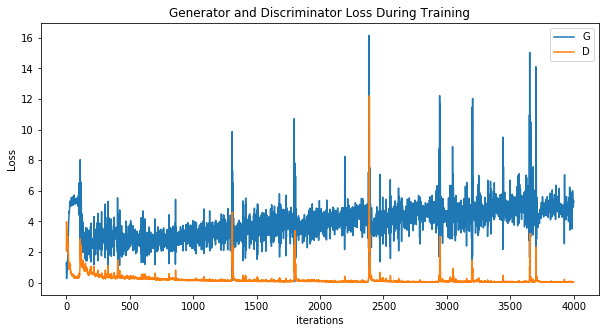

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch after every epoch of training. Now, we can visualize the training progression of G with an animation. Press the play button to start the animation.

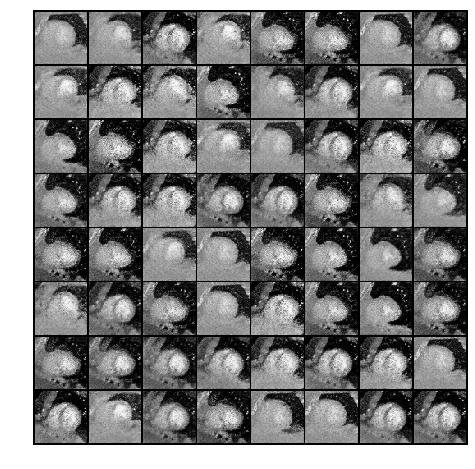

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True, cmap='gray')] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Guardo la imagen en formato gif**

In [14]:
gif_file = 'resultado.gif'

imagenes = []
imagenes_gif = []
for img in img_list:
    img = np.dstack((img.numpy()*256).astype(np.uint8))
    imagenes.append(img)
    for j in range(7):
        imagenes_gif.append(img)
                    
imagenes  = np.array(imagenes)
#imagenes_gif  = np.array(imagenes)

imageio.mimsave(gif_file, imagenes_gif)

**Guardando resultado en formato avi**

In [15]:
import cv2

video_file = 'resultado.avi'

height, width, layers = imagenes[0].shape
size = (width,height)

out = cv2.VideoWriter(video_file,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(imagenes)):
    for j in range(15):
        out.write(imagenes[i])
out.release()

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side.

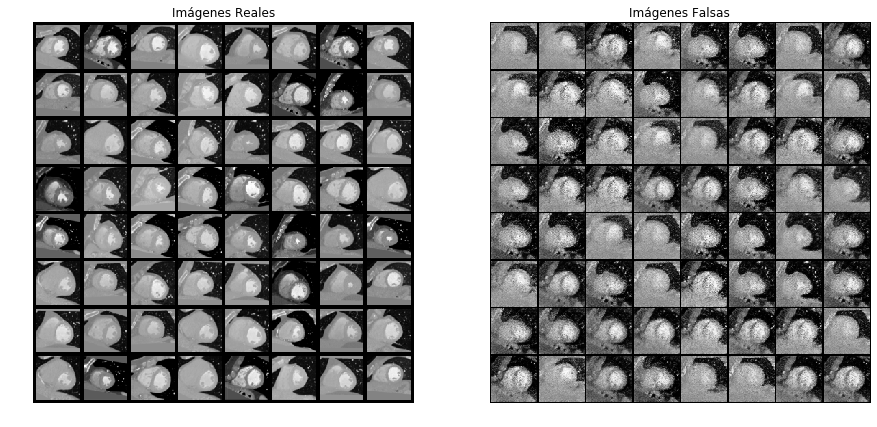

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Imágenes Reales")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imágenes Falsas")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Guardar la comparación
comp_file = 'real vs fake.png'
fig.savefig(comp_file)

**Guardando hyperparámetros**

In [17]:
# Función hash para nombres de folders únicos
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

md_file = 'hyperparametros.md'

with codecs.open(md_file, 'w', 'utf-8') as archivo:
    archivo.write('# Parámetros usados para obtener este resultado\n\n')
    archivo.write('- manualSeed = %d\n' % manualSeed)
    archivo.write('- batch_size = %d\n' % batch_size)
    archivo.write('- image_size = %d\n' % image_size)
    archivo.write('- nz = %d\n' % nz)
    archivo.write('- ngf = %d\n' % ngf)
    archivo.write('- ndf = %d\n' % ndf)
    archivo.write('- num_epochs = %d\n' % num_epochs)
    #archivo.write('- lr = %d\n' % lr)
    archivo.write('- dlr = %f\n' % dlr)
    archivo.write('- glr = %f\n' % glr)
    archivo.write('- beta1 = %f\n' % beta1)

# Creo folder con nombre único basado en los hiperparámetros
folder = md5(md_file)
try:
    os.mkdir('./resultados/'+folder)
    print('Folder creado')
except FileExistsError:
    print('El folder ya existe')

Folder creado


**Guardo diccionarios de estado**

In [29]:
f_models = 'checkpoint.pth' 
torch.save({
            'D_state_dict': netD.state_dict(),
            'G_state_dict': netG.state_dict(),
            #'optimizerD_state_dict': optimizerD.state_dict(),
            #'optimizerG_state_dict': optimizerG.state_dict(),
            }, f_models)

**Muevo todos los archivos al folder creado**

In [30]:
f_list = [md_file,gif_file,video_file,comp_file, f_models]
for fname in f_list:    
    try:    
        os.rename(fname, './resultados/'+folder+'/'+fname)
    except FileExistsError as fexerr:
        print("FileExistsError: {0}".format(fexerr))
    except PermissionError as perr:
        print("PermissionError: {0}".format(perr))
    except FileNotFoundError as fnferr:
        print("FileNotFoundError: {0}".format(fnferr))
                             

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'hyperparametros.md' -> './resultados/58b3fa3e61323c56eb23a10bee6d928c/hyperparametros.md'
FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'resultado.gif' -> './resultados/58b3fa3e61323c56eb23a10bee6d928c/resultado.gif'
FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'resultado.avi' -> './resultados/58b3fa3e61323c56eb23a10bee6d928c/resultado.avi'
FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'real vs fake.png' -> './resultados/58b3fa3e61323c56eb23a10bee6d928c/real vs fake.png'
